# Wedding Seating Optimization

> Objective: Maximize the overall relationship score by optimizing guest seatings within each table and then aggregating these scores across all tables.

# 0. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import random
import itertools
import math
import sys

sys.path.append("..")

from functions.utils import *
from functions.crossover import *
from functions.selection_algos import *
from functions.mutations import *
from functions.algorithms import *
from functions.solutions import *

from itertools import combinations



# 1. EDA

In [2]:
scores = pd.read_csv('data/seating_data(in).csv', index_col=0)

In [3]:
scores_array = scores.to_numpy()
scores_array[0][0]


0

In [4]:
scores

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
idx,,,,,,,,,,,,,,,,,,,,,
1,0,5000,0,0,700,700,0,0,0,0,...,100,100,0,0,100,100,100,0,0,0
2,5000,0,700,700,0,0,300,300,500,500,...,100,100,0,100,0,0,0,0,0,0
3,0,700,0,2000,0,0,0,0,300,300,...,0,0,0,0,0,0,0,0,0,0
4,0,700,2000,0,0,0,900,400,300,300,...,0,0,0,0,0,0,0,0,0,0
5,700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100,0,0,2000,700,700
62,0,0,0,0,0,0,0,0,0,0,...,0,0,-1000,0,100,0,2000,0,700,700


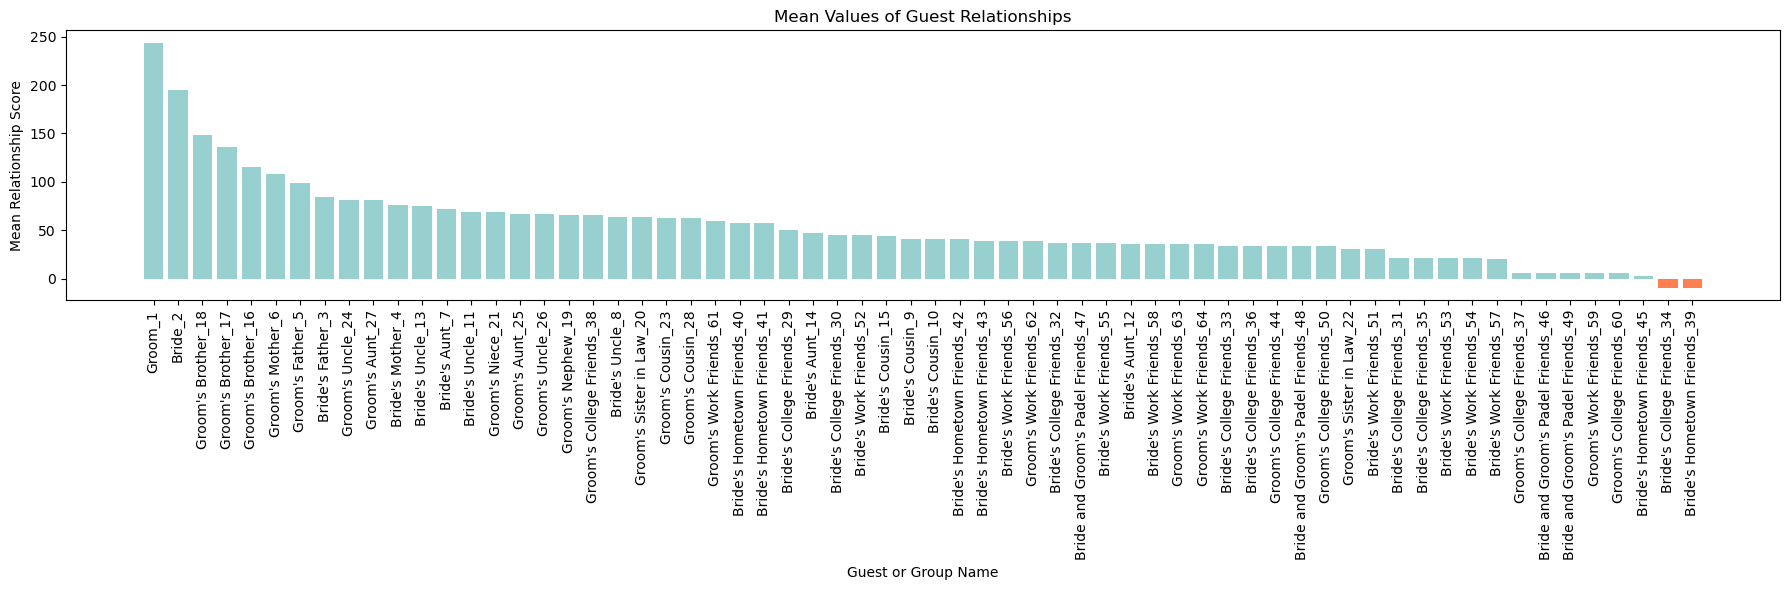

In [5]:
mean_values = {}
for col in scores.columns:
    mean_values[int(col)] = scores[col].mean()

sorted_mean_values = sorted(mean_values.items(), key=lambda x: x[1], reverse=True)

names = {
    "Groom": 1,
    "Bride": 2,
    "Bride's Father": 3,
    "Bride's Mother": 4,
    "Groom's Father": 5,
    "Groom's Mother": 6,
    "Bride's Aunt": [7, 12, 14],
    "Bride's Uncle": [8, 11, 13],
    "Bride's Cousin": [9, 10, 15],
    "Groom's Brother": [16, 17, 18],
    "Groom's Nephew": 19,
    "Groom's Sister in Law": [20, 22],
    "Groom's Niece": 21,
    "Groom's Cousin": [23, 28],
    "Groom's Uncle": [24, 26],
    "Groom's Aunt": [25, 27],
    "Bride's College Friends": [29, 30, 31, 32, 33, 34, 35, 36],
    "Groom's College Friends": [37, 38, 44, 50, 60],
    "Bride's Hometown Friends": [39, 40, 41, 42, 43, 45],
    "Bride and Groom's Padel Friends": [46, 47, 48, 49],
    "Bride's Work Friends": [51, 52, 53, 54, 55, 56, 57, 58],
    "Groom's Work Friends": [59, 61, 62, 63, 64],
}

id_to_name = {}
for name, ids in names.items():
    if isinstance(ids, list):
        for id_ in ids:
            id_to_name[id_] = name
    else:
        id_to_name[ids] = name

named_mean_values = []
for k, v in sorted_mean_values:
    if k in id_to_name:
        name = f"{id_to_name[k]}_{k}"
        named_mean_values.append((name, v))

# Negative colors are in orange
colors = ['#ff7f50' if v[1] < 0 else '#98d0cf' for v in named_mean_values]

plt.figure(figsize=(18, 6))
plt.bar([x[0] for x in named_mean_values], [x[1] for x in named_mean_values], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Guest or Group Name')
plt.ylabel('Mean Relationship Score')
plt.title('Mean Values of Guest Relationships')
plt.tight_layout()
plt.show()

## 1.1 Relationships and meaning of the values

<div style="text-align: center;">
  <img src="guests.png" style="width: 50%;"/>
</div>


| Relationship               | Value  |
|----------------------------|--------|
| Bride or Groom             | 5000   |
| Spouse or Date             | 2000   |
| Best Friend                | 1000   |
| Siblings                   | 900    |
| Parent or Child            | 700    |
| Cousin                     | 500    |
| Aunt/Uncle or Niece/Nephew | 300    |
| Friend                     | 100    |
| Strangers                  | 0      |
| Enemies                    | -1000  |


# 2. Solution representation

> To represent the guests per table we will create a list of tables as such:

| Table Number | Guests   |
| ------------ | -------- |
| 1            | 8 guests |
| 2            | 8 guests |
| 3            | 8 guests |
| 4            | 8 guests |
| 5            | 8 guests |
| 6            | 8 guests |
| 7            | 8 guests |
| 8            | 8 guests |



## 2.1 Wedding Seat Solution

> This is to generate a random initial list of lists

In [6]:
guest_list = list(range(64))
print(guest_list)
random.shuffle(guest_list)
print(guest_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
[6, 51, 54, 30, 17, 9, 11, 42, 4, 52, 32, 60, 46, 41, 31, 56, 0, 5, 34, 40, 19, 20, 35, 43, 36, 10, 26, 29, 58, 25, 13, 2, 63, 37, 44, 62, 12, 49, 47, 14, 59, 18, 16, 27, 28, 7, 53, 57, 55, 33, 45, 38, 21, 48, 3, 8, 23, 24, 15, 61, 50, 39, 1, 22]


In [7]:
table_arrangements = []

for n in range(8):
    table = []
    for i in range(8):
        table.append(guest_list.pop(0))
    table_arrangements.append(table)

print(table_arrangements)


[[6, 51, 54, 30, 17, 9, 11, 42], [4, 52, 32, 60, 46, 41, 31, 56], [0, 5, 34, 40, 19, 20, 35, 43], [36, 10, 26, 29, 58, 25, 13, 2], [63, 37, 44, 62, 12, 49, 47, 14], [59, 18, 16, 27, 28, 7, 53, 57], [55, 33, 45, 38, 21, 48, 3, 8], [23, 24, 15, 61, 50, 39, 1, 22]]


> For fitness function, we need to go through each table:
> - For each pair of guests check their relationship score using the relationship score df.
> - Sum the relationship score for that table.
>  - Sum all the table scores.
$$
\sum _{t\in T} \sum _ {i,j \in G_t i\neq j}  Relationship(i,j)
$$
> - $T = \{t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8\} $ (8 sets of tables)
> - $G_t = $ Guests seated at table $t$
> - $Relationship(i,j)$ is the relationship score between guest $i$ and $j$</br>
> This way, we can calculate the fitness by summing the relationship scores for every pair of $i,j$ guests at each table.

> Note that for each table we can have $(8 \times 7)/2=28$ different pairs.</br>

In [8]:
table_pairs = []
for table in table_arrangements:
    combinations = list(itertools.combinations(table, 2))
    table_pairs.append(combinations)

happy = 0
for table in table_pairs:
    for i, j in table:
        score = scores.iloc[i, j]
        happy += score
print(happy)

18700


## 2.2 Initial population

In [9]:
initial_population = []
for i in range(50):
    new_pop =  Wedding_Solution(scores)
    initial_population.append(new_pop)
initial_population

[
 Table 1: [12, 58, 36, 25, 53, 54, 14, 1]
 Table 2: [8, 3, 35, 41, 27, 40, 64, 34]
 Table 3: [24, 16, 45, 9, 33, 32, 4, 50]
 Table 4: [18, 57, 15, 28, 39, 11, 22, 47]
 Table 5: [23, 2, 62, 60, 17, 42, 21, 10]
 Table 6: [37, 55, 26, 20, 7, 49, 38, 51]
 Table 7: [6, 52, 59, 19, 29, 56, 61, 5]
 Table 8: [30, 44, 63, 31, 48, 13, 46, 43],
 
 Table 1: [3, 30, 54, 36, 19, 44, 39, 27]
 Table 2: [58, 38, 60, 48, 5, 33, 52, 46]
 Table 3: [62, 42, 20, 49, 31, 12, 21, 47]
 Table 4: [61, 40, 23, 8, 17, 34, 10, 50]
 Table 5: [32, 2, 29, 51, 6, 16, 43, 9]
 Table 6: [18, 57, 41, 25, 26, 45, 37, 56]
 Table 7: [53, 64, 15, 4, 22, 59, 63, 24]
 Table 8: [11, 35, 13, 7, 1, 14, 28, 55],
 
 Table 1: [30, 8, 54, 22, 9, 10, 6, 13]
 Table 2: [58, 15, 62, 34, 49, 12, 46, 44]
 Table 3: [29, 47, 42, 1, 45, 60, 53, 37]
 Table 4: [43, 17, 24, 61, 51, 64, 59, 57]
 Table 5: [55, 2, 23, 50, 35, 52, 19, 38]
 Table 6: [21, 28, 11, 16, 63, 41, 32, 33]
 Table 7: [7, 26, 25, 36, 40, 18, 56, 39]
 Table 8: [27, 20, 4, 3, 5,

# 4. Selection algorithm

> We will build the Ranking Selection and Tournament Selection based on the Vanneschi & Silva book's description of the algorithms.

## 4.2 Ranking Selection

> Let $N$ be the total population size, then each individual will be assigned a rank $r \in [1,N]$ based on their fitness:
>
> - Maximization: 1 = Worst fitness, N = Best fitness
> - Minimization: 1 = Best fitness, N = Worst fitness
>
> Since the higher the rank number, then larger the probability of being selected.</br>

> Once the individuals are ranked, to determine the probability of being chosen we need to select a function $\phi$: </br>
>- **Linear**:
>$$P(\text{selecting }i)=\frac{\text{rank}(i)}{\sum^N_{j=1} \text{rank}(j)}$$
>- **Exponential**:
>$$P(\text{selecting } i)=\frac{e^{-\lambda \cdot(N-\text{rank}(i))}}{\sum^N_{j=1}e^{-\lambda\cdot (N-\text{rank}(j))}}$$
>Note: $\lambda$ denotes the selection pressure - where higher values mean that top-ranked individuals will have exponentially higher probability of being selected.

> And to select an individual, we will use the same code from the ``fitness_proportionate`` selection.

> Let's take a look at the effect of $\lambda$ on the probability of being selected in a maximization problem:

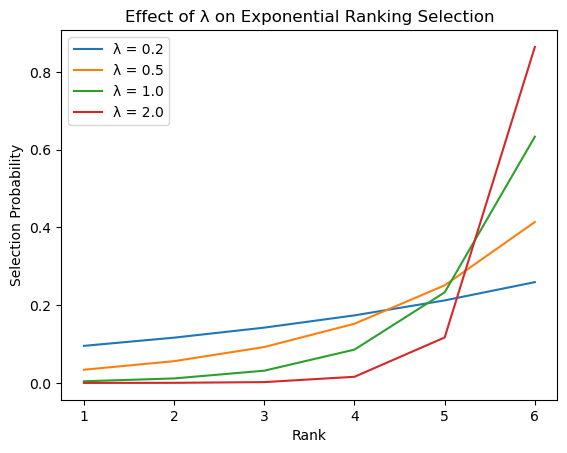

In [10]:
# Fitness values of a population from 1-6
fitness_values = [i for i in range(1, 7)]

# Function to call the exponential probailities based on rank
def exponential_probabilities(n, l):
    ranking = list(range(1, n + 1))  # Rank individuals
    denominator = sum(math.exp(-l * (n - rank)) for rank in ranking)
    probabilities = [math.exp(-l * (n - rank)) / denominator for rank in ranking]
    return probabilities

# Different lambda values
l_values = [0.2, 0.5, 1.0, 2.0]
n = len(fitness_values)

for l in l_values:
    probability = exponential_probabilities(n, l)
    plt.plot(range(1, n + 1), probability, label=f"λ = {l}")

plt.xlabel("Rank")
plt.ylabel("Selection Probability")
plt.title("Effect of λ on Exponential Ranking Selection")
plt.legend()
plt.show()

# 5. Crossover

> We will measure structure disruption (inverse of proportion pairs of guests present in children) for our crossover and mutation operators|

In [11]:
def structure_disruption(
    p: list[list[int]], 
    c: list[list[int]]
    ) -> float:
    """
    Calculates the structural disruption between parent and child seating arrangements.

    Args:
        p (list[list[int]]): Parent seating arrangement, a 2D list with 8 tables of 8 guest IDs.
        c (list[list[int]]): Child seating arrangement, a 2D list with 8 tables of 8 guest IDs.

    Returns:
        float: Disruption score (0 = no disruption, 1 = full disruption) based on the proportion of guest pairs that no longer share a table.
    """
    def get_same_table_pairs(tables: list[list[int]]) -> set[tuple[int, int]]:
        pairs = set()
        for table in tables:
            for g1, g2 in itertools.combinations(sorted(table), 2):
                pairs.add((g1, g2))
        return pairs
    p_pairs = get_same_table_pairs(p)
    c_pairs = get_same_table_pairs(c)
    preserved = p_pairs & c_pairs
    return 1 - (len(preserved) / len(p_pairs)) if p_pairs else 0.0

/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_62211/3752789529.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([disruptions_pmx, disruptions_group, disruptions_p_original, disruptions_group_original], labels=["PMX Block", "Group-Preserving OX", "Classic PMX", "Classic OX"])
/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_62211/3752789529.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([disruptions_pmx, disruptions_group], labels=["PMX Block", "Group-Preserving OX"])


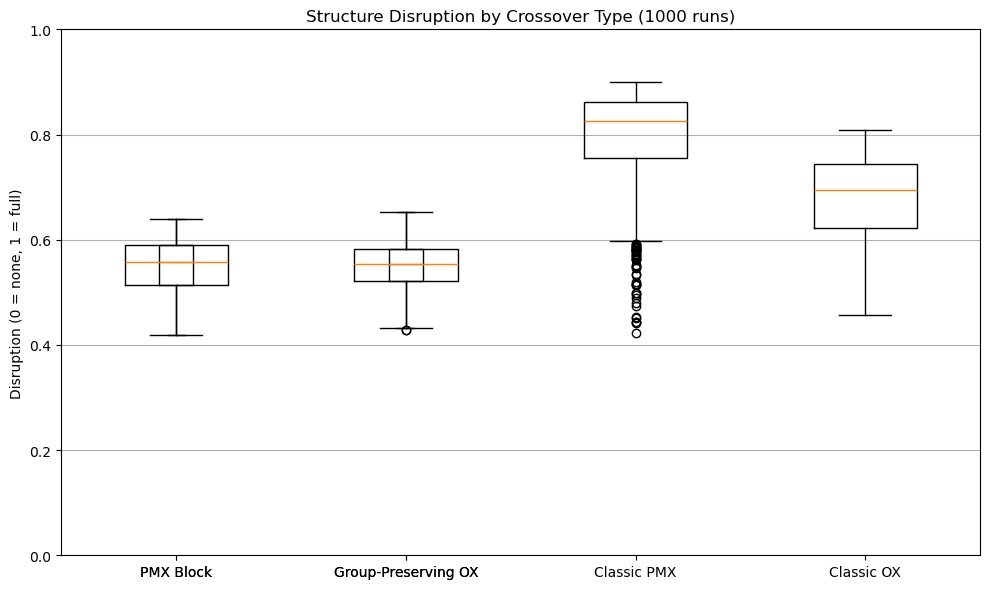

In [12]:

disruptions_pmx = []
disruptions_group = []
disruptions_p_original = []
disruptions_group_original = []
runs = 1000

for _ in range(runs):
    parent1 = list(range(1, 65))
    random.shuffle(parent1)
    parent1 = [parent1[i:i + 8] for i in range(0, 64, 8)]
    
    parent2 = list(range(1, 65))
    random.shuffle(parent2)
    parent2 = [parent2[i:i + 8] for i in range(0, 64, 8)]
    
    c1, c2 = pmx_table_block_crossover(parent1, parent2)
    c3, c4 = group_preserving_order_crossover(parent1, parent2)
    c5, c6 = classic_order_crossover(parent1, parent2)
    c7, c8 = partially_mapped_crossover(parent1, parent2)
    
    d1_mean = (structure_disruption(parent1, c1) + structure_disruption(parent2, c1)) / 2
    d2_mean = (structure_disruption(parent1, c2) + structure_disruption(parent2, c2)) / 2
    d3_mean = (structure_disruption(parent1, c3) + structure_disruption(parent2, c3)) / 2
    d4_mean = (structure_disruption(parent1, c4) + structure_disruption(parent2, c4)) / 2
    d5_mean = (structure_disruption(parent1, c5) + structure_disruption(parent2, c5)) / 2
    d6_mean = (structure_disruption(parent1, c6) + structure_disruption(parent2, c6)) / 2
    d7_mean = (structure_disruption(parent1, c7) + structure_disruption(parent2, c7)) / 2
    d8_mean = (structure_disruption(parent1, c8) + structure_disruption(parent2, c8)) / 2

    d_final_pmx = (d1_mean + d2_mean) / 2
    d_final_group = (d3_mean + d4_mean) / 2
    d_final_cx = (d5_mean + d6_mean) / 2
    d_final_pmx_classic = (d7_mean + d8_mean) / 2

    disruptions_pmx.append(d_final_pmx)
    disruptions_group.append(d_final_group)
    disruptions_p_original.append(d_final_cx)
    disruptions_group_original.append(d_final_pmx_classic)
    

# Plotting side-by-side boxplots
plt.figure(figsize=(10, 6))
plt.boxplot([disruptions_pmx, disruptions_group, disruptions_p_original, disruptions_group_original], labels=["PMX Block", "Group-Preserving OX", "Classic PMX", "Classic OX"])
plt.boxplot([disruptions_pmx, disruptions_group], labels=["PMX Block", "Group-Preserving OX"])
plt.ylim(0, 1)
plt.title("Structure Disruption by Crossover Type (1000 runs)")
plt.ylabel("Disruption (0 = none, 1 = full)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [13]:
c1

[[48, 24, 11, 2, 51, 23, 16, 34],
 [22, 47, 64, 8, 21, 45, 46, 32],
 [54, 37, 9, 27, 5, 6, 31, 57],
 [38, 40, 7, 4, 33, 29, 26, 61],
 [52, 20, 28, 53, 18, 49, 39, 3],
 [36, 19, 25, 50, 1, 41, 60, 17],
 [35, 58, 55, 30, 59, 13, 62, 42],
 [56, 10, 15, 63, 43, 12, 44, 14]]

In [14]:
parent1

[[35, 32, 52, 17, 41, 42, 2, 20],
 [44, 14, 28, 63, 19, 64, 40, 5],
 [38, 62, 7, 10, 33, 29, 50, 61],
 [48, 58, 11, 39, 25, 59, 16, 15],
 [51, 4, 34, 9, 47, 22, 23, 24],
 [54, 37, 30, 27, 49, 1, 31, 57],
 [60, 36, 13, 18, 21, 45, 46, 3],
 [43, 55, 56, 53, 6, 8, 12, 26]]

# 6. Mutation

/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_62211/32937645.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([disruptions_swap, disruptions_inversion, disruptions_scramble], labels=["Swap", "Inversion", "Scramble"])


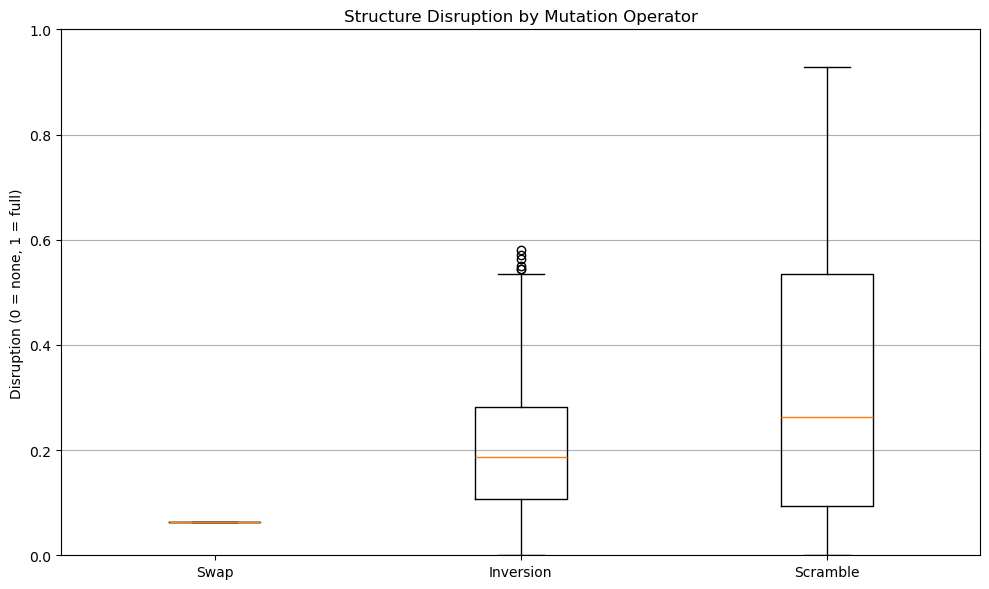

In [15]:

disruptions_swap = []
disruptions_scramble = []
disruptions_inversion = []

runs = 1000

for _ in range(runs):
    parent1 = list(range(1, 65))
    random.shuffle(parent1)
    parent1 = [parent1[i:i + 8] for i in range(0, 64, 8)]
    

    c1 = swap_mutation(parent1, 1)
    c2 = scramble_mutation_optimized(parent1, 1)
    c3 = inversion_mutation(parent1, 1)
    
    dist_c1_p1 = structure_disruption(parent1, c1)
    dist_c2_p1 = structure_disruption(parent1, c2)
    dist_c3_p1 = structure_disruption(parent1, c3)
    
    disruptions_swap.append(dist_c1_p1)
    disruptions_scramble.append(dist_c2_p1)
    disruptions_inversion.append(dist_c3_p1)
    


# Plotting side-by-side boxplots
plt.figure(figsize=(10, 6))
plt.boxplot([disruptions_swap, disruptions_inversion, disruptions_scramble], labels=["Swap", "Inversion", "Scramble"])
plt.ylim(0, 1)
plt.title("Structure Disruption by Mutation Operator")
plt.ylabel("Disruption (0 = none, 1 = full)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()




/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_62211/3597462713.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([disruptions_scramble_1, disruptions_scramble_2, disruptions_scramble_3], labels=["Scramble (k=1)", "Scramble (k=2)", "Scramble (k=3)"])


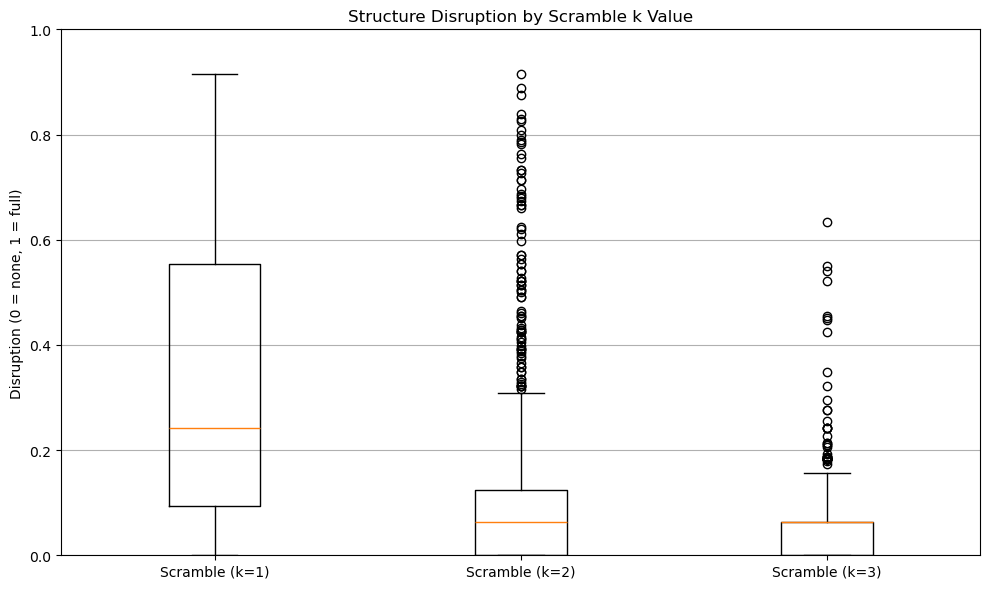

In [16]:

disruptions_scramble_1 = []
disruptions_scramble_2 = []
disruptions_scramble_3 = []

runs = 1000

for _ in range(runs):
    parent1 = list(range(1, 65))
    random.shuffle(parent1)
    parent1 = [parent1[i:i + 8] for i in range(0, 64, 8)]
    

    c1 = scramble_mutation_optimized(parent1, 1, k=1)
    c2 = scramble_mutation_optimized(parent1, 1, k=2)
    c3 = scramble_mutation_optimized(parent1, 1, k=3)
    
    dist_c1_p1 = structure_disruption(parent1, c1)
    dist_c2_p1 = structure_disruption(parent1, c2)
    dist_c3_p1 = structure_disruption(parent1, c3)
    
    disruptions_scramble_1.append(dist_c1_p1)
    disruptions_scramble_2.append(dist_c2_p1)
    disruptions_scramble_3.append(dist_c3_p1)
    


plt.figure(figsize=(10, 6))
plt.boxplot([disruptions_scramble_1, disruptions_scramble_2, disruptions_scramble_3], labels=["Scramble (k=1)", "Scramble (k=2)", "Scramble (k=3)"])
plt.ylim(0, 1)
plt.title("Structure Disruption by Scramble k Value")
plt.ylabel("Disruption (0 = none, 1 = full)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
